In [1]:
import torch
import copy
import umap
import argparse
import numpy as np
from numpy import genfromtxt
import difflib
import matplotlib
import networkx as nx
import community
from matplotlib import colors
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Setting plot parameters

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 24

greens = plt.get_cmap('Greens')
purples = plt.get_cmap('Purples')
greys = plt.get_cmap('Greys')
viridis = plt.get_cmap('viridis')
pastel = plt.get_cmap('Pastel2',5)
plt.rc('lines',linewidth=2)
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE - 4, frameon=False)    # legend fontsize
plt.rc('text', usetex=True)
#plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False})
plt.rcParams['pdf.fonttype'] = 42

### Specify parameters

In [3]:
device = torch.device('cpu')
N = 100 # No. of input nodes i.e. behaviours
#R = 20 # No. of descending neurons i.e. bottleneck layer
M = N # No. of motor units, output
n = 10 # No. of responding output nodes
fn = n/M # Fraction of output nodes that are responding
response_threshold = 0.5 # Whether an input corresponds to activating the node or not
loss_series = []

In [4]:
R_list = [5, 7, 8, 10, 12, 14, 16, 20, 25, 30, 40, 50, 60, 80, 100]
noise = [0, 1, 3, 5, 8]

* noise 8 modularity = 0.18
* 5 = 0.24
* 3 = 0.46
* 1 = 0.68
* 0 = 0.80

### Generate input matrix (identity)

In [5]:
x_in = [[1 if i==j else 0 for i in range(N)] for j in range(N)]
x = torch.tensor(x_in).float()

### Defining useful functions

In [6]:
# Activation function
def actfn(x):
    y = x.sigmoid()
    return y

In [7]:
def load_params (i, j, k):
    device = 'cpu'
    # i= {0} = R, hidden_layer, j = {1} = noise, k = {2} = disorder sample
    b1 =  torch.tensor(np.loadtxt('parameters_boulder_270420/bias1_5.0_{}_10_{}_{}.dat'.format(i, j, k)), dtype=torch.float32, device=device)
    b2 =  torch.tensor(np.loadtxt('parameters_boulder_270420/bias2_5.0_{}_10_{}_{}.dat'.format(i, j, k)), dtype=torch.float32, device=device)
    w1 =  torch.tensor(np.loadtxt('parameters_boulder_270420/weights1_5.0_{}_10_{}_{}.dat'.format(i, j, k)), dtype=torch.float32, device=device)
    w2 =  torch.tensor(np.loadtxt('parameters_boulder_270420/weights2_5.0_{}_10_{}_{}.dat'.format(i, j, k)), dtype=torch.float32, device=device)

    return b1, b2, w1, w2

In [8]:
def prediction (x, b1, b2, w1, w2):
    y_pred = actfn(actfn(x.mm(w1)+b1).mm(w2)+b2)
    y_pred_binary = np.abs(np.round(y_pred.data.numpy()))
    
    return y_pred_binary

### Context dependency functions

In [9]:
# Adding an activated unit
activated_units = 1
x_act = torch.zeros((N,N+activated_units))
for i in range(len(x)):
    x_act[i] = torch.cat((x[i],torch.ones(activated_units,dtype=torch.float32)))

In [10]:
def affect (R, N, activated_units, b1, b2, w1, w2, y_pred_binary):

    motor_units = [[] for i in range(len(y_pred_binary))] # Which hidden neurons affect each motor unit
    hidden_affected = np.zeros(R) # No. of behaviours affected by each hidden neuron
    MI = []
    stereotypy = []
    
    for i in range(R):
        activated_hidden = torch.zeros(R)
        activated_hidden[i] = 1000
    
        w_act = torch.zeros((N+activated_units, R))
        for j in range(len(w_act)):
            if j < N:
                w_act[j] = w1[j]
            else:
                w_act[j] = activated_hidden
            
        # Modified predictions of the NN
        y_pred_2 = actfn(actfn(x_act.mm(w_act)+b1).mm(w2)+b2)
        y_pred_2 = y_pred_2.detach().numpy()
        y_pred_2 = np.abs(np.round(y_pred_2))  # Threshold = 0.5
        comparison_array = (y_pred_2)*2 + y_pred_binary
    
        for k in range(len(comparison_array)):
            for indx, comp in enumerate(comparison_array[k]):
                if comp == 1 or comp == 2:
                    motor_units[indx].append(i+1)
                    
        # Number of behaviours each hidden neuron affects
        for k in range(len(comparison_array)):
            for indx, comp in enumerate(comparison_array[k]):
                if comp == 1 or comp == 2:
                    hidden_affected[i] += 1
                    break
                    
        # Calculate the mutual information
        stim_status = np.zeros(N)
        
        for i in range(N):
            if np.array_equal(y_pred_2[i], y_pred_binary[i]):
            #s = difflib.SequenceMatcher(None, y_pred_2[i],y_pred_binary[i])
            #if s.ratio() > 0.99:
                stim_status[i] += 1
            else:
                modified_indices = [j for j in range(N) if j!=i]
                for k in modified_indices:
                    #s = difflib.SequenceMatcher(None, y_pred_2[i],y_pred_binary[k])
                    #if s.ratio() > 0.99:
                    if np.array_equal(y_pred_2[i], y_pred_binary[k]):
                        stim_status[k] += 1
                        
        non_zero = np.nonzero(stim_status)
        final_stim_status = stim_status[non_zero]
        stereotyped_inputs = np.where(final_stim_status > 1)[0]
        stereotypy.append(sum(final_stim_status[stereotyped_inputs]))
        MI.append(sum((1/N)*np.log2(N/final_stim_status)))
           
    n = (sum(hidden_affected)/R)
    avg_unaffected_behaviours = N-n
    MI_avg = (sum(MI)/R)
    stereotypy_avg = (sum(stereotypy)/R)
    
    return avg_unaffected_behaviours, MI_avg, stereotypy_avg, hidden_affected

In [11]:
def affected_mean (R_list, affected_bhv_list):

    bhv_mean = np.zeros(len(R_list))
    bhv_std = np.zeros(len(R_list))

    for i in range(len(R_list)):
        bhv_mean[i] = np.mean(np.array(affected_bhv_list[i]))
        bhv_std[i] = np.std(np.array(affected_bhv_list[i]))
    return bhv_mean, bhv_std

# Figure 4a

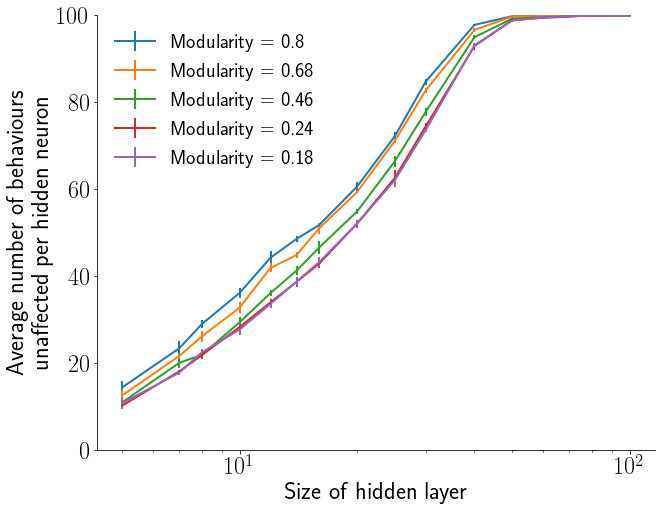

In [12]:
modularity = [0.80, 0.68, 0.46, 0.24, 0.18]

plt.figure(figsize=(10,8))

for j in range(len(noise)):
    n = noise[j]
    unaffected_bhv_list = []

    for i in range(len(R_list)):
        R = R_list[i]
        tmp = []
        
        for index in range(1,6):
            b1, b2, w1, w2 = load_params (float(R), n, index)
            y_pred_binary = prediction (x, b1, b2, w1.T, w2.T)
            avg_unaffected_behaviours, _, _, _ = affect (R, N, activated_units, b1, b2, w1.T, w2.T, y_pred_binary)
            tmp.append(avg_unaffected_behaviours)
        unaffected_bhv_list.append(tmp)
        
    bhv_mean, bhv_std = affected_mean(R_list, unaffected_bhv_list)
    
    plt.errorbar(np.array(R_list), bhv_mean, bhv_std, label = 'Modularity = {}'.format(modularity[j]))

plt.xlabel('Size of hidden layer')
plt.ylabel('Average number of behaviours \n unaffected per hidden neuron')
plt.semilogx()
plt.legend()
plt.ylim(0,100)
plt.savefig('beh_unaffected_modularity.pdf', bbox_inches='tight')

# Figure 4b

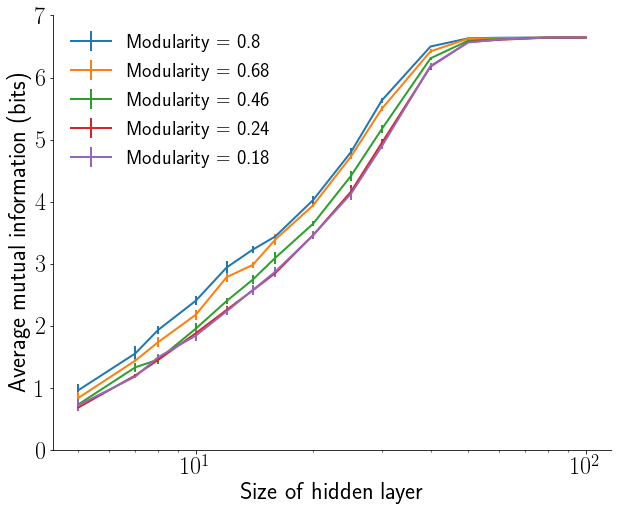

In [13]:
modularity = [0.80, 0.68, 0.46, 0.24, 0.18]

plt.figure(figsize=(10,8))

for j in range(len(noise)):
    n = noise[j]
    MI_list = []

    for i in range(len(R_list)):
        R = R_list[i]
        tmp = []
        
        for index in range(1,6):
            b1, b2, w1, w2 = load_epistasis (float(R), n, index)
            y_pred_binary = prediction (x, b1, b2, w1.T, w2.T)
            _, avg_MI, _, _ = affect (R, N, activated_units, b1, b2, w1.T, w2.T, y_pred_binary)
            tmp.append(avg_MI)
        MI_list.append(tmp)
        
    bhv_mean, bhv_std = affected_mean(R_list, MI_list)
    
    plt.errorbar(np.array(R_list), bhv_mean, bhv_std, label = 'Modularity = {}'.format(modularity[j]))

plt.xlabel('Size of hidden layer')
plt.ylabel('Average mutual information (bits)')
plt.semilogx()
plt.legend()
plt.ylim(0,7)
plt.savefig('beh_unaffected_MI.pdf', bbox_inches='tight')